In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
#import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec

#from cmcrameri import cm
from scipy.stats import linregress
#from scipy.ndimage import gaussian_filter
#from scipy.optimize import curve_fit

from src.Segmentation3D import *
from src.PlottingFunctions import *
from src.CellSegmentation import *
from src.HolomonitorFunctions import *

In [3]:
# experimental parameters
max_frame = 120
frames_per_hour = 4

n0 = 1.33
nd = 1.4

In [129]:
# filter parameters

# min track lenght
min_len_plot = 30
min_len_stat = 20

# outlier limit
median_lim = 0.5

# accepted difference in A or h
diff_lim = 0.3

In [130]:
# choose data set
file = "A2P1"
folder = "../../data/Tomocube/MDCK_10.02.2025/"
search_range = 50

#folder = "../../data/Holomonitor/MDCK_19.03.2024/"
#file = "A1-12"
#search_range = 10


# load data
df = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")

# track cells. Remove when redone
tracks_raw = tp.link(df[df.frame < max_frame], search_range=search_range, memory=5)
tracks = tp.filter_stubs(tracks_raw, 5)
tracks = tracks.reset_index(drop=True)

Frame 39: 989 trajectories present.


In [131]:
# filter out tracks shorter than min_len
particles = []
track_len = []

for p in range(max(tracks.particle)):
    particles.append(p)
    track_len.append(sum(tracks.particle==p))

particles = np.array(particles)
track_len = np.array(track_len)

long_tracks_plot = particles[track_len >= min_len_plot]
long_tracks_stat = particles[track_len >= min_len_stat]
print(f"Number of tracks longer than {min_len_plot/frames_per_hour:0.1f} hours:\n{len(long_tracks_plot)}\n")
print(f"Number of tracks longer than {min_len_stat/frames_per_hour:0.1f} hours:\n{len(long_tracks_stat)}")

Number of tracks longer than 7.5 hours:
539

Number of tracks longer than 5.0 hours:
807


In [132]:
# filter out dividing cells and segmentation errors

good_tracks_plot = []
h_cell = []
A_cell = []
V_cell = []
n_cell = []
t_cell = []


for p in long_tracks_stat:
    mask = (tracks.particle == p)

    # mask that exludes outlier points
    dist_from_median = abs(tracks[mask].V - np.median(tracks[mask].V)) / np.median(tracks[mask].V)
    not_outliers = (dist_from_median <= median_lim)

    # compute change in A and h between consecutive frames
    dA = abs(np.diff(tracks[mask][not_outliers].A)      / (tracks[mask][not_outliers].A[1:]))
    dh = abs(np.diff(tracks[mask][not_outliers].h_avrg) / (tracks[mask][not_outliers].h_avrg[1:]))

    # mask that excludes tracks with large changes 
    not_spurious = (dA.values <= diff_lim)*(dh.values <= diff_lim)

    # accept track if no large changes in A or h, and not too many outliers
    if np.sum(not_spurious) == len(not_spurious) and sum(not_outliers) >= min_len_stat:
        V_cell.append(tracks[mask][not_outliers].V.values)
        A_cell.append(tracks[mask][not_outliers].A.values)
        h_cell.append(tracks[mask][not_outliers].h_avrg.values)
        n_cell.append(tracks[mask][not_outliers].n_avrg.values)
        t_cell.append(tracks[mask][not_outliers].frame.values / frames_per_hour)

        if p in long_tracks_plot and sum(not_outliers) >= min_len_plot:
            good_tracks_plot.append(p)

print(f"Number of good tracks for plotting:\n{len(good_tracks_plot)}\n")
print(f"Number of good tracks for stats:\n{len(t_cell)}")

Number of good tracks for plotting:
173

Number of good tracks for stats:
329


In [133]:
A_decrease = [2, 5, 12, 18, 24, 20, 23, 24, 25, 30, 44, 46, 57, 59, 86, 98, 103]
A_increase = [3, 4, 9, 10, 14, 16, 17, 21, 34, 38, 39, 42, 45, 48, 50, 51, 52, 56, 60, 62, 63, 64, 65, 66, 69, 71, 72, \
               73, 75, 78, 89, 80, 83, 84, 85, 87, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 106, 107, 108, \
               109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130] # 117
A_fluct =  [1, 6, 7, 8, 11, 13, 15, 19, 22, 26, 27, 28, 29, 32, 36, 37, 40, 41, 47, 49, 53, 54, 55, 58, 61, 67, 68, 70, 74, 76, 77, 81, 82, 88, 89, 90, 93, 112, 126] # 0

plot_mask = np.concatenate([np.random.choice(A_decrease, 9, replace=False), np.random.choice(A_increase, 9, replace=False), np.random.choice(A_fluct, 9, replace=False)])
plot_mask = np.sort(plot_mask)
plot_mask

array([  2,   8,  14,  23,  25,  29,  44,  47,  54,  57,  59,  62,  66,
        70,  71,  73,  77,  86,  88,  89,  91,  97,  98, 103, 105, 119,
       126])

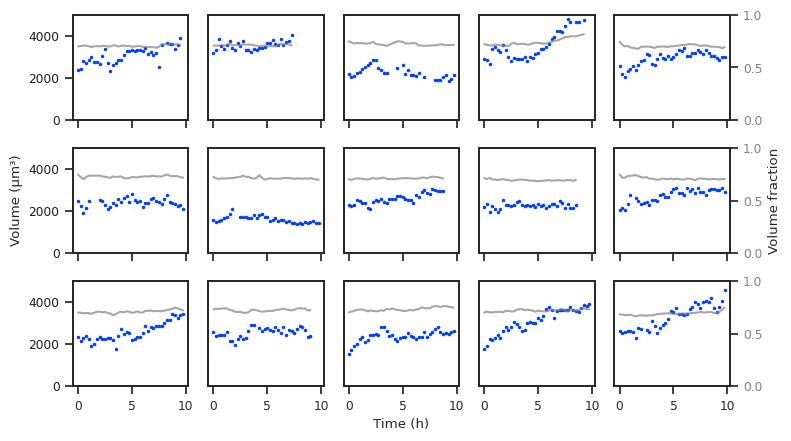

In [134]:
sns.set_theme(style='ticks', palette='bright', font_scale=0.8)
fig, axes = plt.subplots(3,5, figsize=(8,4.5), sharex=True)#, sharey=True)

i = 0
for ax in axes.flatten():

    # twin axis for volume fraction
    ax1 = ax.twinx()

    # mask specific track
    mask = (tracks.particle == good_tracks_plot[plot_mask[i]])
    
    # compute mask that avoids outliers
    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))

    # compute volume fraction
    v_frac = (tracks[mask][outlier].n_avrg - n0) / (nd - n0)
    
    # plot volume
    ax.plot(tracks[mask][outlier].frame / 4, (tracks[mask][outlier].V), 'b.', ms=3)

    # plot dry mass
    ax1.plot(tracks[mask][outlier].frame / 4, (v_frac), '-', color="gray", ms=2, alpha=0.7)


    # axes specifications
    if (i+1)%5 != 0:
        ax1.set_yticks([])
    else:
        ax1.set_yticks([0, .5, 1])
    if (i)%5 != 0:
        ax.set_yticks([])
    if i==9:
        ax1.set(ylabel="Volume fraction")

    ax1.set(ylim=(0,1))
    ax .set(ylim=(0, 5e3))
    ax .set_xticks([0, 5, 10])
    ax .tick_params(axis='y', labelcolor='k')
    ax1.tick_params(axis='y', labelcolor='gray')


    i += 1


axes[1,0].set(ylabel="Volume (µm³)")
axes[2,2].set(xlabel="Time (h)")
fig.tight_layout()

In [135]:
fig.savefig(f"../../figs/paper/figure5a.pdf", dpi=300)

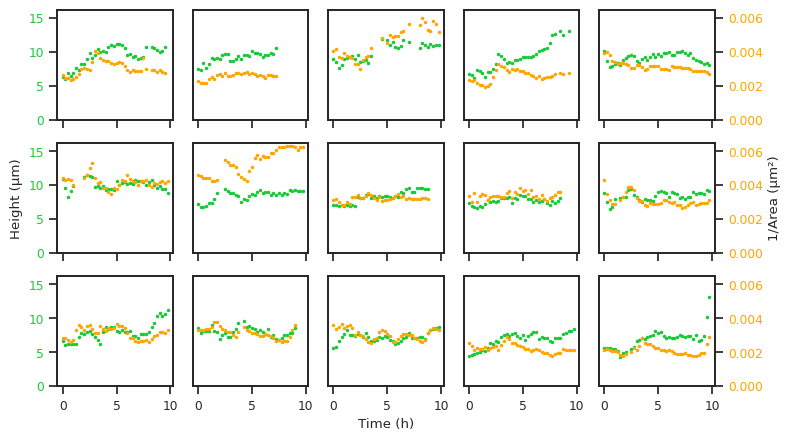

In [136]:
# figure S3
sns.set_theme(style='ticks', palette='bright', font_scale=0.8)
fig, axes = plt.subplots(3,5, figsize=(8,4.5), sharex=True)#, sharey=True)

i = 0
idx = 0
for ax in axes.flatten():

    # twin axis for area
    ax1 = ax.twinx()

    # mask specific track
    mask = (tracks.particle == good_tracks_plot[plot_mask[i]])

    # compute mask that avoids outliers
    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    
    # smoothen curve for visuals
    #mu_h = gaussian_filter(tracks[mask][outlier].h_avrg, sigma=1.5)
    #mu_A = gaussian_filter(1/tracks[mask][outlier].A,    sigma=1.5)

    # plot height
    #ax.plot(tracks[mask][outlier].frame / 4, mu_h, 'g-', alpha=0.7)
    ax.plot(tracks[mask][outlier].frame / 4, (tracks[mask][outlier].h_avrg), 'g.', ms=3)

    # plot area
    #ax1.plot(tracks[mask][outlier].frame / 4, mu_A, '-', alpha=0.7, color="orange")
    ax1.plot(tracks[mask][outlier].frame / 4, 1/(tracks[mask][outlier].A), '.', ms=3, color="orange")


    # axes specifications
    if (i+1)%5 != 0:
        ax1.set_yticks([])
    #else:
    #    ax1.set_yticks([0, .5, 1])
    if (i)%5 != 0:
        ax.set_yticks([])
    if i==9:
        ax1.set(ylabel="1/Area (µm²)")

    ax1.set(ylim=(0,0.0065))
    ax .set(ylim=(0,2500*0.0065))
    ax .set_xticks([0, 5, 10])
    ax.tick_params(axis='y', labelcolor='g')
    ax1.tick_params(axis='y', labelcolor='orange')



    i += 1

axes[1,0].set(ylabel="Height (µm)")
axes[2,2].set(xlabel="Time (h)")
fig.tight_layout()

In [137]:
fig.savefig(f"../../figs/paper/figureS3.pdf", dpi=300)

In [138]:
def get_fluctuations(t_arr, arr):
    fit = linregress(t_arr, arr)
    lin_fit = fit.intercept + t_arr*fit.slope
    return np.std(arr-lin_fit) / np.mean(arr)

V_fluct = []
A_fluct = []
h_fluct = []
n_fluct = []
v_fluct = []

for i in range(len(V_cell)):
    V_fluct.append(get_fluctuations(t_cell[i], V_cell[i])*100)
    A_fluct.append(get_fluctuations(t_cell[i], A_cell[i])*100)
    h_fluct.append(get_fluctuations(t_cell[i], h_cell[i])*100)
    n_fluct.append(get_fluctuations(t_cell[i], n_cell[i])*100)

    v = (np.array(n_cell[i])-n0) / (nd-n0)
    v_fluct.append(100*np.std(v) / np.mean(v))


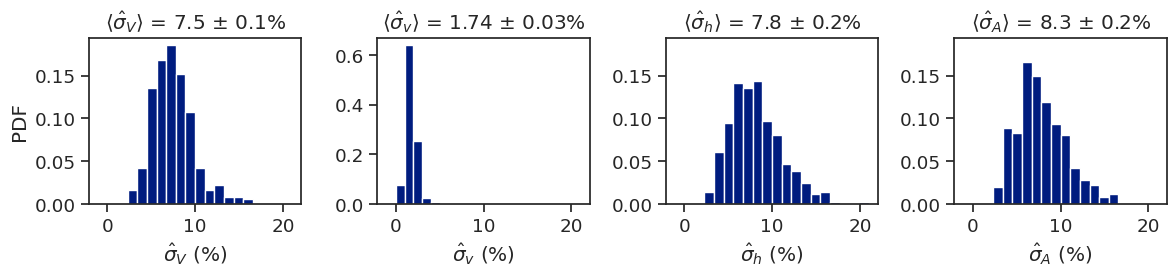

In [140]:
bins = 20
hist_range = [-1,21]

fig = plt.figure(figsize=(12,3))
sns.set_theme(style='ticks', palette='dark', font_scale=1.2)

ax0 = fig.add_subplot(1, 4, 1)
ax1 = fig.add_subplot(1, 4, 2)
ax2 = fig.add_subplot(1, 4, 3, sharey = ax0)
ax3 = fig.add_subplot(1, 4, 4, sharey = ax0)

ax0.hist(V_fluct, density="True", bins=bins,   range=hist_range)
ax1.hist(v_fluct, density="True", bins=bins+2, range=hist_range)
ax2.hist(A_fluct, density="True", bins=bins,   range=hist_range)
ax3.hist(h_fluct, density="True", bins=bins,   range=hist_range)

ax0.set(title=rf"$\langle \hat{{\sigma}}_V \rangle$ = {np.mean(V_fluct):0.1f} $\pm$ {np.std(V_fluct) / np.sqrt(len(V_fluct)):0.1f}%", xlabel=r"$\hat{\sigma}_V$ (%)")
ax1.set(title=rf"$\langle \hat{{\sigma}}_v \rangle$ = {np.mean(v_fluct):0.2f} $\pm$ {np.std(v_fluct) / np.sqrt(len(V_fluct)):0.2f}%", xlabel=r"$\hat{\sigma}_v$ (%)")
ax2.set(title=rf"$\langle \hat{{\sigma}}_h \rangle$ = {np.mean(h_fluct):0.1f} $\pm$ {np.std(h_fluct) / np.sqrt(len(V_fluct)):0.1f}%", xlabel=r"$\hat{\sigma}_h$ (%)")
ax3.set(title=rf"$\langle \hat{{\sigma}}_A \rangle$ = {np.mean(A_fluct):0.1f} $\pm$ {np.std(A_fluct) / np.sqrt(len(V_fluct)):0.1f}%", xlabel=r"$\hat{\sigma}_A$ (%)")
ax0.set(ylabel="PDF")

fig.tight_layout()
fig.savefig("../../figs/paper/figure5b.pdf", dpi=300)